### Deep Learning in the Eye Tracking World 
#### the tutorial presented during ETRA 2021 (https://etra.acm.org/2021/acceptedtutorials.html)
#### the code downloaded from: https://github.com/kasprowski/etra2021
@author: pawel@kasprowski.pl


## Import packages

In [5]:
import cv2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer

### Helper function

In [1]:
def printResults(testLabels,testResults):
    print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
    print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
    print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
    return accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))

## Three methods preparing artificial data for classification

prepare_samples_areas():
- vertical dashes in top-left area for label=0
- vertical dashes in bottom-right area for label=1

prepare_samples_colors():
- white dashes for label=1
- grey dashes for label=0

prepare_samples_direction():
- horizontal dashes for label=1
- vertical dashes for label=0


In [2]:
length = 50 #size of images
size = 100 #number of samples for each class


def prepare_samples_areas():
    samplesIMG = []
    labels = []
    dashes = 50 #number of dashes
    
    #images with lines in NW quarter
    for i in range(size):
        sample = np.zeros((length,length))
        for _ in range(dashes):
            x = random.randrange(0,length/2)
            y = random.randrange(0,length/2)
            sample[x:x+6,y:y+1]=255
        samplesIMG.append(sample)
        labels.append(1)
        if i==0: cv2.imwrite("v.jpg",sample)
    
    #images with lines in SE quarter
    for i in range(size):
        sample = np.zeros((length,length))
        for _ in range(dashes):
            x = random.randrange(length/2,length)
            y = random.randrange(length/2,length)
            sample[x:x+6,y:y+1]=255
        samplesIMG.append(sample)
        labels.append(0)
        if i==0: cv2.imwrite("h.jpg",sample)

    samplesIMG = np.array(samplesIMG)
    labels = np.array(labels)

    #one-hot encoding
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels,2)
    return samplesIMG,labels

def prepare_samples_colors():
    samplesIMG = []
    labels = []
    dashes = 50 #number of dashes
    
    #images with white lines
    for i in range(size):
        sample = np.zeros((length,length))
        for _ in range(dashes):
            x = random.randrange(0,length)
            y = random.randrange(0,length)
            sample[x:x+6,y:y+1]=255
        samplesIMG.append(sample)
        labels.append(1)
        if i==0: cv2.imwrite("v.jpg",sample)
    
    #images with gray lines
    for i in range(size):
        sample = np.zeros((length,length))
        for _ in range(dashes):
            x = random.randrange(0,length)
            y = random.randrange(0,length)
            sample[x:x+6,y:y+1]=125
        samplesIMG.append(sample)
        labels.append(0)
        if i==0: cv2.imwrite("h.jpg",sample)

    samplesIMG = np.array(samplesIMG)
    labels = np.array(labels)

    #one-hot encoding
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels,2)
    return samplesIMG,labels


def prepare_samples_direction():
    samplesIMG = []
    labels = []
    dashes = 100 #number of dashes
    
    #images with horizontal lines
    for i in range(size):
        sample = np.zeros((length,length))
        for _ in range(dashes):
            x = random.randrange(0,length)
            y = random.randrange(0,length)
            sample[x:x+6,y:y+1]=255
        samplesIMG.append(sample)
        labels.append(1)
        if i==0: cv2.imwrite("h.jpg",sample)
    
    #images with vertical lines
    for i in range(size):
        sample = np.zeros((length,length))
        for _ in range(dashes):
            x = random.randrange(0,length)
            y = random.randrange(0,length)
            sample[x:x+1,y:y+6]=255
        samplesIMG.append(sample)
        labels.append(0)
        if i==0: cv2.imwrite("v.jpg",sample)

    samplesIMG = np.array(samplesIMG)
    labels = np.array(labels)

    #one-hot encoding
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels,2)
    return samplesIMG,labels

## Tree methods that:
1. build the model using trainSamples and trainlabels
2. return labels predicted by the model for testSamples

- tree() - DecisionTree
- flat_network() - classic Multilayer Perceptrion
- cnn_network() - example of Convolutional Neural Network


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from tensorflow.keras.layers import Activation,Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from tensorflow.keras.models import Sequential

def tree(trainSamples, trainLabels, testSamples):
    # samples must be flat (i.e. one dimensional) for tree!
    length = trainSamples.shape[1]
    trainSamples = trainSamples.reshape(-1,length*length)
    testSamples = testSamples.reshape(-1,length*length)
    model = RandomForestClassifier(n_estimators=20)
    model.fit(trainSamples, trainLabels)    
    testResults = model.predict(testSamples)
    return testResults

def flat_network(trainSamples, trainLabels, testSamples):
    # samples must be flat (i.e. one dimensional) for MLP!
    length = trainSamples.shape[1]
    trainSamples = trainSamples.reshape(-1,length*length)
    testSamples = testSamples.reshape(-1,length*length)

    classes_number = trainLabels.shape[1]
    
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(classes_number, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy'])
    EPOCHS = 20
    BATCH=50
    model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS)
    testResults = model.predict(testSamples)
    return testResults
    
def cnn_network(trainSamples, trainLabels, testSamples):
  
    # samples must be 3D for CNN!
    trainSamples = np.expand_dims(trainSamples, axis=3)
    testSamples = np.expand_dims(testSamples, axis=3)

    classes_number = trainLabels.shape[1]

    length = trainSamples.shape[1]
    inputShape = (length,length,1)

    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("sigmoid"))
    model.add(Dense(512))
    model.add(Activation("sigmoid"))
    model.add(Dense(classes_number))
    model.add(Activation("softmax"))

    model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy'])
    EPOCHS = 20
    BATCH=50
    model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS)
    testResults = model.predict(testSamples)
    return testResults


## Creating a dataset using one of the methods

255.0


C:\programs\miniconda3\envs\deep\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


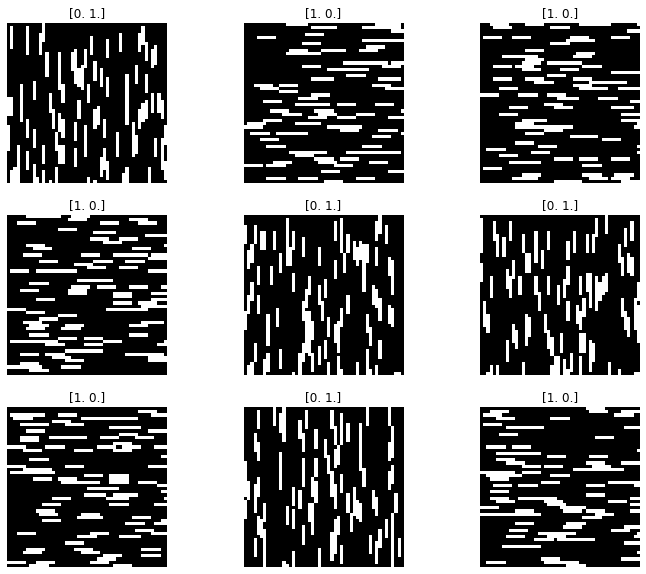

In [16]:
#samples,labels = prepare_samples_areas()
#samples,labels = prepare_samples_colors()
samples,labels = prepare_samples_direction()

print(samples.max())
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n],cmap='gray')
    plt.title(labels[n])
    plt.axis("off")

## Test all three models using the given dataset

In [17]:
(trainSamples, testSamples, trainLabels, testLabels) = train_test_split(samples, labels, test_size=0.25, random_state=42)

print("TREE")
testResults = tree(trainSamples,trainLabels,testSamples)
accTree = printResults(testLabels, testResults)

print("+"*100)
print("MLP - FLAT")
testResults = flat_network(trainSamples,trainLabels,testSamples)
accFlat = printResults(testLabels, testResults)
        
print("+"*100)
print("CNN")
testResults = cnn_network(trainSamples,trainLabels,testSamples)
accCnn = printResults(testLabels, testResults)

print("Accuracy TREE: {}".format(accTree))
print("Accuracy FLAT: {}".format(accFlat))
print("Accuracy CNN: {}".format(accCnn))

TREE
[[22  1]
 [11 16]]
              precision    recall  f1-score   support

           0       0.67      0.96      0.79        23
           1       0.94      0.59      0.73        27

    accuracy                           0.76        50
   macro avg       0.80      0.77      0.76        50
weighted avg       0.81      0.76      0.75        50

Cohen's Kappa: 0.53198127925117
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
MLP - FLAT
Epoch 1/20
3/3 [==============================] - 0s 4ms/step - loss: 0.8257 - accuracy: 0.4800
Epoch 2/20
3/3 [==============================] - 0s 1ms/step - loss: 0.6476 - accuracy: 0.6000
Epoch 3/20
3/3 [==============================] - 0s 0s/step - loss: 0.5513 - accuracy: 0.7133
Epoch 4/20
3/3 [==============================] - 0s 6ms/step - loss: 0.5028 - accuracy: 0.7733
Epoch 5/20
3/3 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.8200
Epoch 6/20
3/3 [==========

<ipython-input-18-80b8b2b657d1>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(labels)


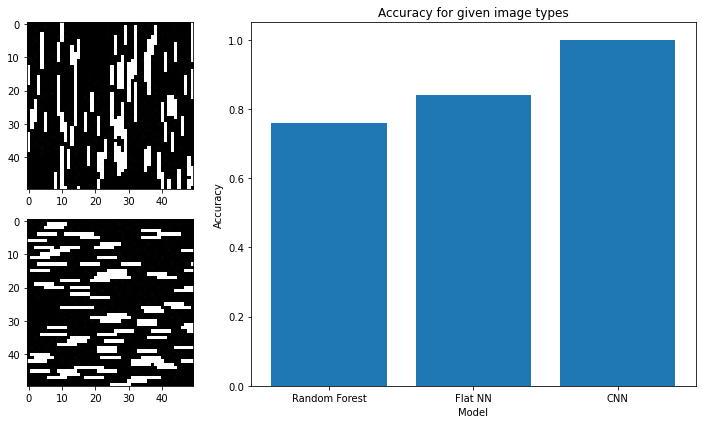

In [18]:
def plot_accuracy(values):
    hfig = cv2.imread('h.jpg')
    vfig = cv2.imread('v.jpg')
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    axs[0,0].imshow(hfig)
    axs[1,0].imshow(vfig)
    axs[0,1].remove()
    axs[1,1].remove()
    axs[0,2].remove()
    axs[1,2].remove()
    gs = axs[0,1].get_gridspec()
    labels = ["Random Forest","Flat NN","CNN"]
    p = fig.add_subplot(gs[:, 1:])
    p.bar(labels, values)
    p.set_xlabel('Model')
    p.set_ylabel('Accuracy')
    p.set_xticklabels(labels)
    p.set_title('Accuracy for given image types')
    fig.tight_layout()
    plt.show()
plot_accuracy((accTree,accFlat,accCnn))

